In [8]:
import torch
import gc
from consistory_run import load_pipeline, run_anchor_generation
from consistory_utils import StoryPipelineStore
import random
from matplotlib import pyplot as plt
import pickle
from datetime import datetime
import json
import argparse
import logging
import yaml
import os
import shutil
import numpy as np

def find_token_ids(tokenizer, prompt, words):
    tokens = tokenizer.encode(prompt)
    ids = []
    if isinstance(words, str):
                  words = [words]
    for word in words:
        for i, token in enumerate(tokens):
            if tokenizer.decode(token) == word:
                ids.append(i)
                break
    assert len(ids) != 0 , 'Cannot find the word in the prompt.'
    return ids
    

In [9]:
    config_path = '/workspace/Diploma/config/config.yaml'
    prompt_path = '/workspace/Diploma/config/prompt.yaml'
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    with open(prompt_path, "r") as f:
        prompt = yaml.safe_load(f)
    with open("/workspace/Diploma/PATH.json","r") as f:
        ENV_CONFIGS = json.load(f)


In [10]:
    subject = prompt['target_prompt']
    concept_token = [prompt['base']]

    device = config['device']
    pipeline = DiffusionPipeline.from_pretrained(ENV_CONFIGS['paths']['sdxl_path']).to(device)

    if 'g_seed' not in list(config.keys()):
        seed = random.randint(0, 10000)
    else:
        seed = config['g_seed']
    mask_dropout = 0.5
    same_latent = False

    os.makedirs(config['experiments_dir'], exist_ok=True)
    now = datetime.now()


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.73it/s]


In [12]:
    gpu = 0
    story_pipeline = load_pipeline(gpu)
    
    story_pipeline_store = StoryPipelineStore()
    token_id = find_token_ids(story_pipeline.tokenizer, subject, concept_token)

    # Reset the GPU memory tracking
    torch.cuda.reset_max_memory_allocated(gpu)
    settings = [""] * 10
    
    random_settings = random.sample(settings, 2)
    prompts = [f'{subject} {setting}' for setting in random_settings]
    anchor_out_images, anchor_image_all, anchor_cache_first_stage = \
            run_anchor_generation(story_pipeline, prompts, concept_token, 
                           seed=seed, mask_dropout=mask_dropout, same_latent=same_latent,
                           cache_cpu_offloading=True, story_pipeline_store=story_pipeline_store)


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 13.36it/s]


[(1, 30)]


  0%|          | 0/30 [00:00<?, ?it/s]/workspace/Diploma/OneActor/diffusers/utils/torch_utils.py:106: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:41.)
  x_freq = fftn(x, dim=(-2, -1))
/workspace/oa_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


In [183]:
    torch.cuda.empty_cache()
import torch.nn.functional as F

    data_list = {}
    image_list = {}
    kernel_size = 5
    n = 0
    for i in range(len(story_pipeline_store.first_stage.images)):
        n_samples = len(story_pipeline_store.first_stage.images[i])
        for j in range(n_samples):
            image_list[f"img_{n}"] = story_pipeline_store.first_stage.images[i][j]
            mask = story_pipeline_store.first_stage.last_masks[i][64][j].reshape(64,64).cpu() * 1
            mask = mask.to(dtype=torch.float32)
            mask = mask.unsqueeze(0).unsqueeze(0)
            kernel = torch.ones((1, 1, kernel_size, kernel_size), dtype=torch.float32) / (kernel_size * kernel_size)
            padding = (kernel_size - 1) // 2
            mask = F.conv2d(mask, kernel, padding=padding).squeeze()  # Remove the extra dimensions
    
            # Apply the final transformation
            mask = mask * 0.6 + torch.ones(size=(64, 64)) * 0.25 + (mask > 0) * 0.15
            data_list[f"img_{n}"] = {
                'xt':[_xt_save[j:j+1] for _xt_save in story_pipeline_store.first_stage.xt_save[i]],
                'h_mid':[_mid_save[j::n_samples]  for _mid_save in story_pipeline_store.first_stage.mid_save_list[i]],
                'prompt_embed':story_pipeline_store.first_stage.prompt_embeds[i][j::n_samples],
                'mask_64': mask, # sum
                'prompt': story_pipeline_store.first_stage.prompt[i][j], 
                'concept_token': concept_token 
            }
            n += 1
    
    keys_list = list(image_list.keys())
    target_key = keys_list[0]


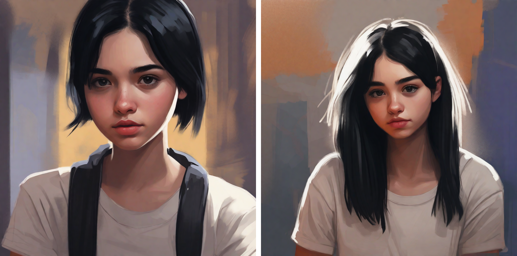

In [184]:
anchor_image_all

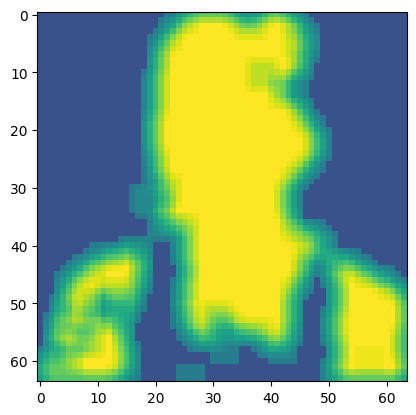

In [185]:
plt.imshow(data_list['img_0']['mask_64'], vmin=0, vmax=1)

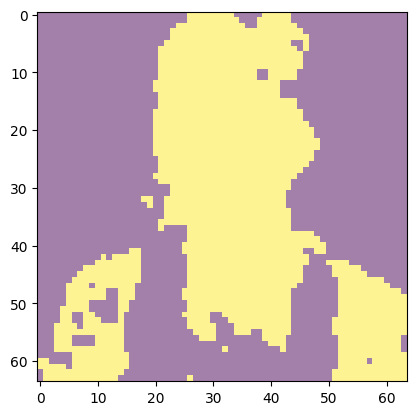

In [138]:
plt.imshow(story_pipeline_store.first_stage.last_masks[0][64][0].reshape(64,64).cpu(), vmin=0, vmax=1, alpha=0.5)